In [1]:
import pandas as pd
import numpy as np
#from geetools import batch
from tqdm import tqdm
import matplotlib.pyplot as plt
import rasterio
from retry import retry 
import math
from pyproj import Proj, transform
import folium
import os
gdal.PushErrorHandler('CPLQuietErrorHandler')
from osgeo import gdal

NameError: name 'gdal' is not defined

## Creating a Matrix from the Multi Spectral Band Image

In [ ]:
#dataset = rasterio.open("./oupt_images/sentinel_image_34.72370492925229_135.32032416848173_['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12'].tif")

dataset = rasterio.open("try/sentinel_image_-17.27346158496977_-42.18262506706492_['B4', 'B3', 'B2'].tif") 

## Retrieve Image Metadata

In [ ]:
dataset.bounds

In [138]:
p = Proj('EPSG:3857', preserve_units=False) 
lon,lat=p(dataset.bounds[0],dataset.bounds[3],inverse=True) # project from EPSG 

In [139]:
angular_Distance=math.degrees(0.5 * ((512 * 10) / 6371000))
lon=lon+angular_Distance
lat=lat-angular_Distance
print(lat)
print(lon)
#Matches the original Long and Latitude

30.56110768446815
106.30498627016678


In [2]:
#takes the file and returns the image array
def get_image_array(file):
    data = rasterio.open(file)
    image=np.zeros((data.width,data.height,data.count),dtype=data.dtypes[0]) #creates matrix of width X Height X number of bands
    for i in range(data.count):
        image[:,:,i]=data.read(i+1)
    new_image=image[:,:,:]/10000
    return new_image

In [ ]:
#example

new_arr=get_image_array("images/sentinel_image_25.90802333676137_-80.35725629189838_['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12'].tif")

## Extracting Specific bands for visualization

In [5]:
band={'B2':0,'B3':1,'B4':2,'B5':3,'B6':4,'B7':5,'B8':6,'B8A':7,'B11':8,'B12':9}
associated_color={'B2':"Blue",'B3':"Green",'B4':"Red",'B5':"RedEdge1",'B6':"RegEdge2",'B7':"RedEdge3",'B8':"NIR",'B8A':"RedEdge4",'B11':"SWIR1",'B12':"SWIR2"}
a=['B2','B3','B4','B5','B6','B7','B8','B8A','B11','B12']
#making all band combinations
combination_all=[]
for i in a:
    for j in a:
        for k in a:
            combination_all.append([i,j,k])

In [6]:
def visualize_one_band(new_arr,band_solo):
    band={'B2':0,'B3':1,'B4':2,'B5':3,'B6':4,'B7':5,'B8':6,'B8A':7,'B11':8,'B12':9}
    associated_color={'B2':"Blue",'B3':"Green",'B4':"Red",'B5':"RedEdge1",'B6':"RegEdge2",'B7':"RedEdge3",'B8':"NIR",'B8A':"RedEdge4",'B11':"SWIR1",'B12':"SWIR2"}
    fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(9, 6),
                        subplot_kw={'xticks': [], 'yticks': []})
    ax.imshow(new_arr[:, :, band[band_solo]])
    ax.set_title(str(associated_color[band_solo]),fontsize=10)

    plt.tight_layout()
    plt.show()


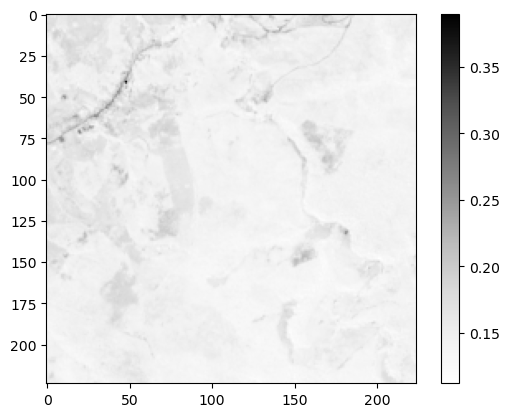

In [7]:
plt.imshow(new_arr[:,:,1], cmap=plt.cm.Greys)
plt.colorbar()

# visualize SAR 1 Data

Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


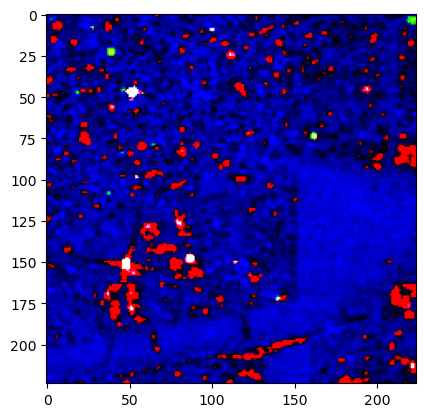

In [21]:

def get_image_array(file):
    data = rasterio.open(file)
    image=np.zeros((data.width,data.height,data.count),dtype=data.dtypes[0]) #creates matrix of width X Height X number of bands
    for i in range(data.count):
        image[:,:,i]=data.read(i+1)
    new_image=image[:,:,:]
    return new_image
new_arr=get_image_array("../test5.tif")
t = new_arr[:, :, 0] / new_arr[:, :, 1]
c = np.zeros((224,224, 3),dtype=float)
c[:, :, 0 ] = new_arr[:, :, 0]
c[:, :, 1 ] = new_arr[:, :, 1]
c[:, :, 2 ] = t
plt.imshow(c)

In [7]:
#contrast functions to make the image brighter
def contrast_one_band(image,band):
    colors = image[:, :, band]#.astype(np.float64)

    max_val = 0.6
    min_val = 0

    # Enforce maximum and minimum values
    colors[colors > max_val] = max_val
    colors[colors< min_val] = min_val
    colors = colors * 1 / (max_val - min_val)

    return colors
def contrast_combo_band(image,band_combo):
    
    colors = image[:, :, band_combo]#.astype(np.float64)

    max_val = 0.6
    min_val = 0

    # Enforce maximum and minimum values
    colors[colors[:, :, :] > max_val] = max_val
    colors[colors[:, :, :] < min_val] = min_val

    for b in range(colors.shape[2]):
        colors[:, :, b] = colors[:, :, b] * 1 / (max_val - min_val)
    return colors
    

## Every Single Band Before Contrasting

In [ ]:
band={'B2':0,'B3':1,'B4':2,'B5':3,'B6':4,'B7':5,'B8':6,'B8A':7,'B11':8,'B12':9}
associated_color={'B2':"Blue",'B3':"Green",'B4':"Red",'B5':"RedEdge1",'B6':"RegEdge2",'B7':"RedEdge3",'B8':"NIR",'B8A':"RedEdge4",'B11':"SWIR1",'B12':"SWIR2"}
fig, axs = plt.subplots(nrows=5, ncols=2,figsize=(15, 30),
                        subplot_kw={'xticks': [], 'yticks': []})
for ax, combo in zip(axs.flat, ['B2','B3','B4','B5','B6','B7','B8','B8A','B11','B12']):
    ax.imshow(new_arr[:, :, band[combo]])
    ax.set_title(str(associated_color[combo]),fontsize=10)
plt.tight_layout()
plt.show()

## Every Single Band After Contrasting

In [ ]:
fig, axs = plt.subplots(nrows=5, ncols=2,figsize=(15, 40),
                        subplot_kw={'xticks': [], 'yticks': []})
for ax, combo in zip(axs.flat, ['B2','B3','B4','B5','B6','B7','B8','B8A','B11','B12']):
    ax.imshow(contrast_one_band(new_arr,band[combo]))
    ax.set_title(str(associated_color[combo]),fontsize=10)

plt.tight_layout()
plt.show()

In [13]:
def visualize_contrast_combination(new_arr,band_combo):
    band={'B2':0,'B3':1,'B4':2,'B5':3,'B6':4,'B7':5,'B8':6,'B8A':7,'B11':8,'B12':9}
    associated_color={'B2':"Blue",'B3':"Green",'B4':"Red",'B5':"RedEdge1",'B6':"RegEdge2",'B7':"RedEdge3",'B8':"NIR",'B8A':"RedEdge4",'B11':"SWIR1",'B12':"SWIR2"}
    fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(5, 5),
                        subplot_kw={'xticks': [], 'yticks': []})
    array_bands=[band[band_combo[0]],band[band_combo[1]],band[band_combo[2]]]
    ax.imshow(contrast_combo_band(new_arr,array_bands))
    ax.set_title(str([associated_color[band_combo[0]],associated_color[band_combo[1]],associated_color[band_combo[2]]]),fontsize=10)

    plt.tight_layout()
    plt.show()



In [10]:
def visualize_one_combination(new_arr,band_combo):
    band={'B2':0,'B3':1,'B4':2,'B5':3,'B6':4,'B7':5,'B8':6,'B8A':7,'B11':8,'B12':9}
    associated_color={'B2':"Blue",'B3':"Green",'B4':"Red",'B5':"RedEdge1",'B6':"RegEdge2",'B7':"RedEdge3",'B8':"NIR",'B8A':"RedEdge4",'B11':"SWIR1",'B12':"SWIR2"}
    fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(9, 6),
                        subplot_kw={'xticks': [], 'yticks': []})
    array_bands=[band[band_combo[0]],band[band_combo[1]],band[band_combo[2]]]
    ax.imshow(new_arr[:,:,array_bands])
    ax.set_title(str([associated_color[band_combo[0]],associated_color[band_combo[1]],associated_color[band_combo[2]]]),fontsize=10)

    plt.tight_layout()
    plt.show()

# Plot 

In [ ]:
new_arr=get_image_array("images/sentinel_image_25.90802333676137_-80.35725629189838_['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12'].tif")
visualize_one_combination(new_arr,['B4','B3','B2'])

RGB

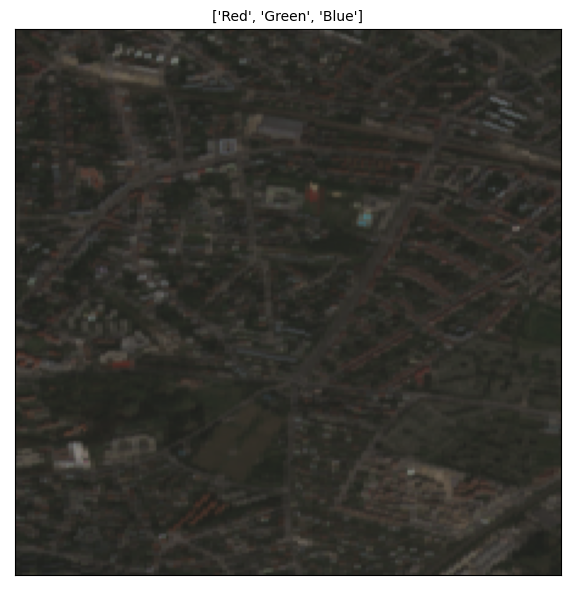

In [27]:
visualize_one_combination(new_arr,['B4','B3','B2'])

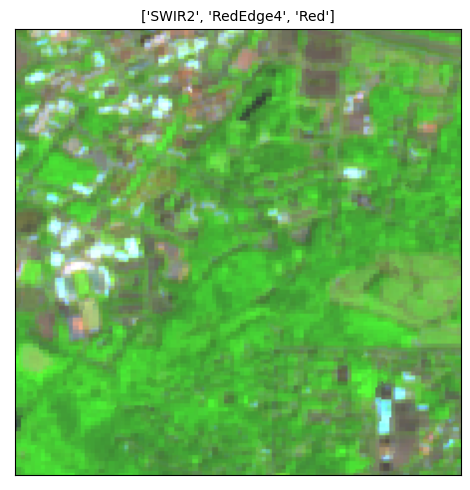

In [24]:
visualize_contrast_combination(new_arr,['B12','B8A','B4'])

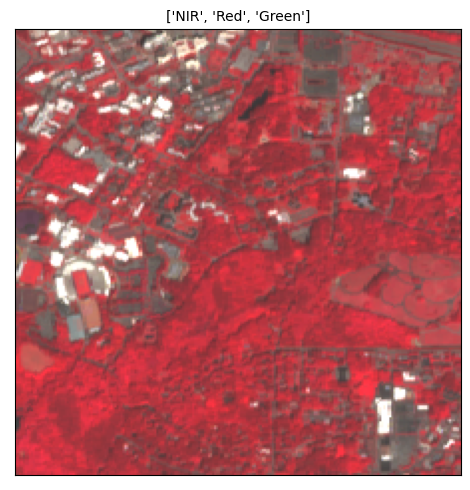

In [22]:
visualize_contrast_combination(new_arr,['B8','B4','B3'])

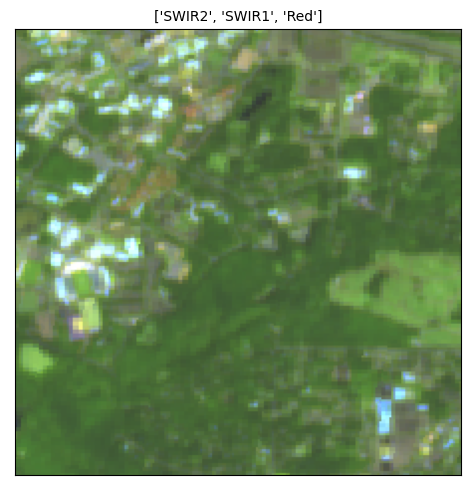

In [23]:
visualize_contrast_combination(new_arr,['B12','B11','B4'])

# Visualize other images

In [3]:
def get_image_array(file):
    data = rasterio.open(file)
    image=np.zeros((data.width,data.height,data.count),dtype=data.dtypes[0]) #creates matrix of width X Height X number of bands
    for i in range(data.count):
        image[:,:,i]=data.read(i+1)
    new_image=image[:,:,:]/10000
    return new_image